# Implementing Integrated DNNs to Predict Bone Age from Hand Radiographs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split
import wandb
from kaggle_secrets import UserSecretsClient


my_secrets = UserSecretsClient()
my_secret = my_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)
%matplotlib inline

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**We start by Discovering the Dataset at hand**

In [2]:
train_path = "/kaggle/input/rsna-bone-age/boneage-training-dataset"
train_df = pd.read_csv(os.path.join("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv"))


train_df['path'] = train_df['id'].map(lambda x: os.path.join(train_path,
                                                             "boneage-training-dataset", f"{x}.png"))

train_df['exists'] = train_df['path'].map(os.path.exists) # Check to see if there are any missing values

train_df.dropna(inplace = True)

print(f"total training samples: {len(train_df)}")
print(f"existing training samples: {sum(train_df.exists)}")

train_df.sample(3)

total training samples: 12611
existing training samples: 12611


,id,boneage,male,path,exists
9796,12474,168,True,/kaggle/input/rsna-bone-age/boneage-training-d...,True
5576,7759,106,False,/kaggle/input/rsna-bone-age/boneage-training-d...,True
11594,14477,156,True,/kaggle/input/rsna-bone-age/boneage-training-d...,True


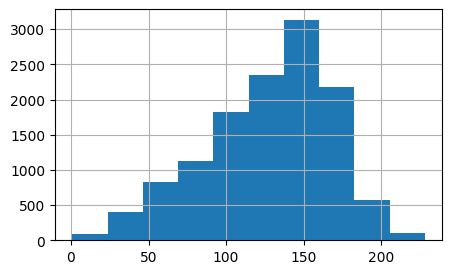

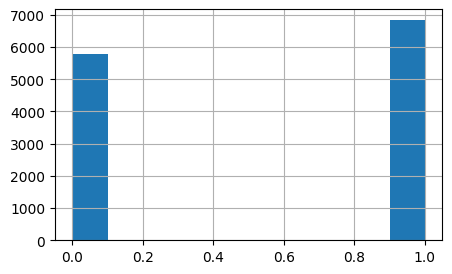

In [3]:
train_df['boneage'].hist(figsize = (5, 3)) # check the distribution of bone age and male prevalence
plt.show()
train_df['male'].astype(int).hist(figsize = (5, 3))
plt.show()

Text(0.5, 1.0, 'Training sample 1377, bone age: 180, male: False')

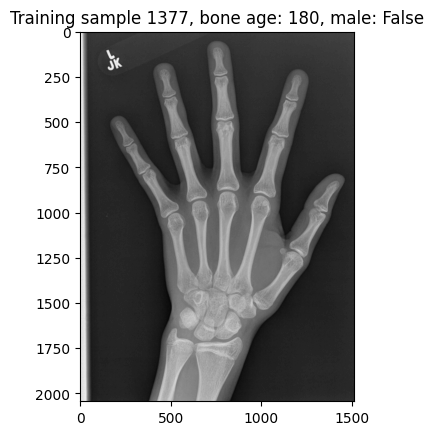

In [4]:
plt.imshow(imread(train_df['path'][0]), cmap = "gray")
plt.title(f"Training sample {train_df.id[0]}, bone age: {train_df.boneage[0]}, male: {train_df.male[0]}")

Next, we should create a validation dataset, to choose the best model. It is good to make sure that both train and validation datasets have labels with similar distributions. Hence, we implement stratified splitting.

In [5]:
stratified_df = train_df.copy()
stratified_df['boneage_category'] = pd.cut(stratified_df['boneage'], 10)
stratified_train_df, stratified_valid_df = train_test_split(stratified_df, test_size = 0.25, random_state = 2024,
                                                     stratify = stratified_df['boneage_category'])
                                        # We use a train to valid ratio of 3:1
print(f"No. of training samples: {len(stratified_train_df)}. \nNo. of validation samples: {len(stratified_valid_df)}.")

No. of training samples: 9458. 
No. of validation samples: 3153.


**We can start building our model here**

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Having a dataset class helps us feed the data to dataloaders. Since we want to use the same dataset class on train, validation, and test data, we use a few "if" statements to make adjustments.

In [7]:
class dataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = imread(row['path'])
        male = row['male'].astype(float)
        male = torch.tensor(male, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        if 'boneage' in row.keys(): # for when we are creating test dataset
            label = row['boneage'].astype(float)
            label = torch.tensor(label, dtype=torch.float32)
            return img, male, label
        else:
            return img, male
    def __len__(self):
        return len(self.data)

**Here, we define the main model architecture. We use ResNet-50 to extract the features of radiographic images.
We also create a Dense Neural Net to extract and add the features corresponding to gender.
In the end, both of the aforementioned features are passed through 2 Linear Layers, to predict the bone age.**

In [8]:
class Gender_Model(nn.Module):
    def __init__(self, dense_layer1_size, dense_layer2_size, p_dropout, regressor_layer_size):
        super(Gender_Model, self).__init__()
        self.resnet = models.resnet50(weights = 'IMAGENET1K_V2')
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.new_conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.new_conv1.weight = nn.Parameter(self.resnet.conv1.weight.mean(dim=1, keepdim=True))
        
        self.resnet.conv1 = self.new_conv1
        self.dense_layer1_size = dense_layer1_size
        self.dense_layer2_size = dense_layer2_size
        self.p_dropout = p_dropout
        self.regressor_layer_size = regressor_layer_size
        
        
        self.gender_dense = nn.Sequential(
            nn.Linear(1, self.dense_layer1_size),
            nn.ReLU(inplace = True),
            nn.Dropout(self.p_dropout),
            nn.Linear(self.dense_layer1_size, self.dense_layer2_size),
            nn.ReLU(inplace = True),
            nn.Dropout(self.p_dropout)
        )

        self.fc1 = nn.Linear(self.dense_layer2_size + num_features, self.regressor_layer_size)
        self.fc2 = nn.Linear(self.regressor_layer_size, 1)
            
    def forward(self, img, gender):
        img_features = self.resnet(img)
        gender_features = self.gender_dense(gender.unsqueeze(1))
        combined_features = torch.cat((img_features, gender_features), dim = 1)
        
        x = self.fc1(combined_features)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        
        return x

In [9]:
def train_one_epoch(train_loader, model, loss, metric, optimizer, scheduler):
    epoch_loss = 0.0
    epoch_metric_val = 0.0
    
    for imgs, genders, labels in train_loader:
        imgs, genders, labels = imgs.to(DEVICE), genders.to(DEVICE), labels.view(-1, 1).to(DEVICE)
        
        predictions = model(imgs, genders)
        running_loss = loss(predictions, labels)
        running_metric_val = metric(predictions, labels)
        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        wandb.log({'step_loss': running_loss,
                   "learning_rate": scheduler.get_last_lr()[0]})
        
        scheduler.step()
        
        epoch_loss += running_loss.item()
        epoch_metric_val += running_metric_val.item()
        
    return epoch_loss/len(train_loader), epoch_metric_val/len(train_loader)

In [10]:
def validate_one_epoch(val_loader, model, loss, metric):
    epoch_loss = 0.0
    epoch_metric_val = 0.0

    with torch.no_grad():
        for imgs, genders, labels in val_loader:
            imgs, genders, labels = imgs.to(DEVICE), genders.to(DEVICE), labels.view(-1, 1).to(DEVICE)
            
            predictions = model(imgs, genders)
            running_loss = loss(predictions, labels)
            running_metric_val = metric(predictions, labels)
            
            epoch_loss += running_loss.item()
            epoch_metric_val += running_metric_val.item()
        
        return epoch_loss/len(val_loader), epoch_metric_val/len(val_loader)

Defining the "main" function, helps us use wandb sweeps to choose the best hyperparameters. Since image size may also be tuned in later versions, we've put transformers here (though this implementation is not necessary).

In [11]:
def main():
    run = wandb.init()
    
    train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(wandb.config.image_size, antialias = None),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(wandb.config.image_size, antialias = None),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    train_set = dataset(stratified_train_df, transform = train_transform)
    val_set = dataset(stratified_valid_df, transform = val_transform)
    
    
    train_loader = DataLoader(train_set, wandb.config.batch_size, shuffle = True,
                              num_workers = 4, pin_memory = True)
    val_loader = DataLoader(val_set, wandb.config.batch_size,
                           num_workers = 4, pin_memory = True)
    
    model = Gender_Model(wandb.config.dense_layer1_size, wandb.config.dense_layer2_size,
                         wandb.config.p_dropout, wandb.config.regressor_layer_size)
    model.to(DEVICE)
    
    loss_f = nn.MSELoss()
    metric = nn.L1Loss()
    
    optimizer = optim.Adam(model.parameters(), lr = wandb.config.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = wandb.config.step_size, gamma = wandb.config.gamma)
    
    for epoch in range(wandb.config.num_epochs):
        best_loss = float("inf")
        best_model_path = "/kaggle/working/best_model.pth"
        
        
        train_loss, train_L1 = train_one_epoch(train_loader, model, loss_f, metric, optimizer, scheduler)
        val_loss, val_L1 = validate_one_epoch(val_loader, model, loss_f, metric)
        
        wandb.log({
        'epoch': epoch, 
        'train_loss': train_loss,
        'train_MAE': train_L1,
        'val_loss': val_loss,
        'val_MAE': val_L1
        })
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
        
        
        print(f"Epoch [{epoch + 1}/{wandb.config.num_epochs}] - Training Loss: {train_loss:.4f} - Training MAE: {train_L1:.4f}")
        print(f"Epoch [{epoch + 1}/{wandb.config.num_epochs}] - Validation Loss: {val_loss:.4f} - Validation MAE: {val_L1:.4f}")


Here we define the sweep configuration to tune the hyperparameters automatically and save them to the cloud.

In [12]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep-bayes_5',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters': 
    {
        'batch_size': {'values': [64, 128]},
        'num_epochs': {'values': [10, 20]},
        'learning_rate': {"values": [0.01, 0.001]},
        'step_size': {"values": [10, 20, 30]},
        'gamma': {"values": [0.1, 0.5, 0.9]},
        'dense_layer1_size': {'values': [128, 256]},
        'dense_layer2_size': {'values': [128, 256]},
        'p_dropout': {'max': 0.5, 'min': 0.1},
        'regressor_layer_size': {'values': [128, 256]},
        'image_size': {'value': (224, 224)}
     }
}

In [13]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="Bone_Age_Assessment_v1")

wandb.agent(sweep_id, function=main, count=5)

Create sweep with ID: 9mhyu2a4
Sweep URL: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/sweeps/9mhyu2a4


wandb: Agent Starting Run: 5zj3hfxh with config:
wandb: 	batch_size: 64
wandb: 	dense_layer1_size: 256
wandb: 	dense_layer2_size: 128
wandb: 	gamma: 0.9
wandb: 	image_size: [224, 224]
wandb: 	learning_rate: 0.01
wandb: 	num_epochs: 20
wandb: 	p_dropout: 0.23281211984432615
wandb: 	regressor_layer_size: 256
wandb: 	step_size: 10
wandb: Currently logged in as: kasra-pirahesh (kpirahesh). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240518_025550-5zj3hfxh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run robust-sweep-1
wandb: ⭐️ View project at https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: 🧹 View sweep at https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/sweeps/9mhyu2a4
wandb: 🚀 View run at https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/5zj3h

Epoch [1/20] - Training Loss: 1848.1417 - Training MAE: 32.8366
Epoch [1/20] - Validation Loss: 1046.1320 - Validation MAE: 25.1055
Epoch [2/20] - Training Loss: 765.0072 - Training MAE: 20.9307
Epoch [2/20] - Validation Loss: 546.9052 - Validation MAE: 17.2120
Epoch [3/20] - Training Loss: 539.1189 - Training MAE: 17.3319
Epoch [3/20] - Validation Loss: 482.1056 - Validation MAE: 15.9862
Epoch [4/20] - Training Loss: 475.1106 - Training MAE: 16.2121
Epoch [4/20] - Validation Loss: 456.4877 - Validation MAE: 15.6577
Epoch [5/20] - Training Loss: 453.9358 - Training MAE: 15.8946
Epoch [5/20] - Validation Loss: 452.7889 - Validation MAE: 15.5626
Epoch [6/20] - Training Loss: 454.6432 - Training MAE: 15.9733
Epoch [6/20] - Validation Loss: 454.1168 - Validation MAE: 15.6665
Epoch [7/20] - Training Loss: 456.7658 - Training MAE: 16.1098
Epoch [7/20] - Validation Loss: 447.0945 - Validation MAE: 15.5416
Epoch [8/20] - Training Loss: 453.3788 - Training MAE: 15.9795
Epoch [8/20] - Validation

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb: learning_rate █▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     step_loss █▆▅▂▃▃▂▂▂▄▁▂▂▂▄▃▂▁▁▂▂▄▂▂▂▂▁▁▂▂▁▂▁▁▂▂▂▃▁▁
wandb:     train_MAE █▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       val_MAE █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      val_loss █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         epoch 19
wandb: learning_rate 0.0
wandb:     step_loss 405.99915
wandb:     train_MAE 16.08278
wandb:    train_loss 453.92567
wandb:       val_MAE 15.50284
wandb:      val_loss 443.1906
wandb: 
wandb: 🚀 View run robust-sweep-1 at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/5zj3hfxh
wandb: ⭐️ View project at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240518_025550-5z

Epoch [1/20] - Training Loss: 1121.6613 - Training MAE: 20.0945
Epoch [1/20] - Validation Loss: 186.0701 - Validation MAE: 10.4075
Epoch [2/20] - Training Loss: 179.2532 - Training MAE: 10.3905
Epoch [2/20] - Validation Loss: 179.2074 - Validation MAE: 10.3188
Epoch [3/20] - Training Loss: 151.8475 - Training MAE: 9.5365
Epoch [3/20] - Validation Loss: 165.1541 - Validation MAE: 9.8407
Epoch [4/20] - Training Loss: 150.5315 - Training MAE: 9.4930
Epoch [4/20] - Validation Loss: 162.6389 - Validation MAE: 9.8196
Epoch [5/20] - Training Loss: 149.2109 - Training MAE: 9.4530
Epoch [5/20] - Validation Loss: 162.7887 - Validation MAE: 9.7940
Epoch [6/20] - Training Loss: 151.1142 - Training MAE: 9.5248
Epoch [6/20] - Validation Loss: 163.0356 - Validation MAE: 9.7657
Epoch [7/20] - Training Loss: 146.8582 - Training MAE: 9.3760
Epoch [7/20] - Validation Loss: 163.5874 - Validation MAE: 9.8416
Epoch [8/20] - Training Loss: 147.2636 - Training MAE: 9.4342
Epoch [8/20] - Validation Loss: 163.7

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb: learning_rate █▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     step_loss █▆▃▂▃▃▅▁▂▂▂▂▂▂▃▂▄▂▂▁▃▄▂▃▃▃▂▂▃▄▁▃▂▂▃▃▂▃▁▃
wandb:     train_MAE █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       val_MAE █▇▂▂▁▁▂▂▁▁▂▂▁▂▂▂▂▂▂▂
wandb:      val_loss █▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         epoch 19
wandb: learning_rate 0.0
wandb:     step_loss 176.59514
wandb:     train_MAE 9.38695
wandb:    train_loss 146.80816
wandb:       val_MAE 9.85959
wandb:      val_loss 164.05997
wandb: 
wandb: 🚀 View run radiant-sweep-2 at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/mya1j9f8
wandb: ⭐️ View project at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240518_035239-my

Epoch [1/10] - Training Loss: 1148.3930 - Training MAE: 20.5831
Epoch [1/10] - Validation Loss: 317.0591 - Validation MAE: 14.0862
Epoch [2/10] - Training Loss: 298.7471 - Training MAE: 13.7681
Epoch [2/10] - Validation Loss: 317.4170 - Validation MAE: 14.0881
Epoch [3/10] - Training Loss: 300.8506 - Training MAE: 13.7857
Epoch [3/10] - Validation Loss: 316.9319 - Validation MAE: 14.0714
Epoch [4/10] - Training Loss: 299.8949 - Training MAE: 13.8238
Epoch [4/10] - Validation Loss: 317.8157 - Validation MAE: 14.0922
Epoch [5/10] - Training Loss: 304.2333 - Training MAE: 13.8563
Epoch [5/10] - Validation Loss: 317.9735 - Validation MAE: 14.0957
Epoch [6/10] - Training Loss: 300.7007 - Training MAE: 13.7730
Epoch [6/10] - Validation Loss: 316.7071 - Validation MAE: 14.0757
Epoch [7/10] - Training Loss: 297.3883 - Training MAE: 13.6888
Epoch [7/10] - Validation Loss: 318.3152 - Validation MAE: 14.1096
Epoch [8/10] - Training Loss: 296.1423 - Training MAE: 13.7344
Epoch [8/10] - Validation 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▂▃▃▄▅▆▆▇█
wandb: learning_rate █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     step_loss █▄▄▃▂▂▂▂▃▄▃▂▂▂▂▂▂▃▂▂▄▂▃▃▂▂▃▄▄▂▂▃▁▄▃▂▂▂▂▄
wandb:     train_MAE █▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▁▁▁▁▁▁▁▁▁
wandb:       val_MAE ▄▄▁▅▆▂█▅▁▃
wandb:      val_loss ▃▄▂▆▇▁█▅▁▂
wandb: 
wandb: Run summary:
wandb:         epoch 9
wandb: learning_rate 0.0
wandb:     step_loss 257.82315
wandb:     train_MAE 13.66824
wandb:    train_loss 295.05038
wandb:       val_MAE 14.0787
wandb:      val_loss 316.96563
wandb: 
wandb: 🚀 View run effortless-sweep-3 at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/es3lgys4
wandb: ⭐️ View project at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240518_044849-es3lgys4/logs
wandb: Agent Starting Run: jma59590

Epoch [1/20] - Training Loss: 1488.8367 - Training MAE: 24.2761
Epoch [1/20] - Validation Loss: 214.7168 - Validation MAE: 11.4117
Epoch [2/20] - Training Loss: 194.8075 - Training MAE: 10.8708
Epoch [2/20] - Validation Loss: 178.0816 - Validation MAE: 10.3833
Epoch [3/20] - Training Loss: 168.2849 - Training MAE: 10.0815
Epoch [3/20] - Validation Loss: 171.6226 - Validation MAE: 10.1896
Epoch [4/20] - Training Loss: 164.0149 - Training MAE: 9.9483
Epoch [4/20] - Validation Loss: 173.3500 - Validation MAE: 10.2734
Epoch [5/20] - Training Loss: 163.8927 - Training MAE: 9.9175
Epoch [5/20] - Validation Loss: 171.5639 - Validation MAE: 10.1872
Epoch [6/20] - Training Loss: 161.5416 - Training MAE: 9.8528
Epoch [6/20] - Validation Loss: 170.4382 - Validation MAE: 10.1774
Epoch [7/20] - Training Loss: 163.6759 - Training MAE: 9.9501
Epoch [7/20] - Validation Loss: 170.3102 - Validation MAE: 10.1488
Epoch [8/20] - Training Loss: 159.0690 - Training MAE: 9.8423
Epoch [8/20] - Validation Loss:

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb: learning_rate █▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     step_loss █▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▂▁▂▁▁▁▁▂▂
wandb:     train_MAE █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       val_MAE █▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      val_loss █▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         epoch 19
wandb: learning_rate 0.0
wandb:     step_loss 70.15076
wandb:     train_MAE 9.84256
wandb:    train_loss 161.1308
wandb:       val_MAE 10.18522
wandb:      val_loss 171.17906
wandb: 
wandb: 🚀 View run glamorous-sweep-4 at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/jma59590
wandb: ⭐️ View project at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240518_051724-j

Epoch [1/20] - Training Loss: 2022.7265 - Training MAE: 27.2577
Epoch [1/20] - Validation Loss: 265.7911 - Validation MAE: 12.7463
Epoch [2/20] - Training Loss: 189.4054 - Training MAE: 10.7241
Epoch [2/20] - Validation Loss: 162.4757 - Validation MAE: 9.8413
Epoch [3/20] - Training Loss: 141.3754 - Training MAE: 9.2049
Epoch [3/20] - Validation Loss: 143.6527 - Validation MAE: 9.2266
Epoch [4/20] - Training Loss: 138.1102 - Training MAE: 9.0841
Epoch [4/20] - Validation Loss: 136.0962 - Validation MAE: 8.9701
Epoch [5/20] - Training Loss: 129.9828 - Training MAE: 8.8708
Epoch [5/20] - Validation Loss: 141.7521 - Validation MAE: 9.1609
Epoch [6/20] - Training Loss: 128.2234 - Training MAE: 8.7885
Epoch [6/20] - Validation Loss: 138.7327 - Validation MAE: 9.0321
Epoch [7/20] - Training Loss: 124.9284 - Training MAE: 8.7064
Epoch [7/20] - Validation Loss: 137.7706 - Validation MAE: 9.0419
Epoch [8/20] - Training Loss: 131.6124 - Training MAE: 8.8639
Epoch [8/20] - Validation Loss: 137.85

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb: learning_rate █▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     step_loss █▃▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▂▂▁▁▁▂▁▁▂▂▂▁▁▁▂▁▁▁▂▁▂▂▁
wandb:     train_MAE █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:       val_MAE █▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      val_loss █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         epoch 19
wandb: learning_rate 0.0
wandb:     step_loss 115.44717
wandb:     train_MAE 8.64137
wandb:    train_loss 124.63123
wandb:       val_MAE 8.99239
wandb:      val_loss 137.01776
wandb: 
wandb: 🚀 View run soft-sweep-5 at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1/runs/8zox89rw
wandb: ⭐️ View project at: https://wandb.ai/kpirahesh/Bone_Age_Assessment_v1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240518_061503-8zox8

**And finally, we can predict the bone ages for the test data here.**

In [14]:
test_path = "/kaggle/input/rsna-bone-age/boneage-test-dataset"

test_df = pd.read_csv(os.path.join("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv"))
test_df['path'] = test_df['Case ID'].map(lambda x: os.path.join(test_path,
                                                             "boneage-test-dataset", f"{x}.png"))
test_df['exists'] = test_df['path'].map(os.path.exists)
test_df["male"] = test_df.Sex.map({'M': 1, 'F': 0})

print(f"total test samples: {len(test_df)}")

total test samples: 200


In [15]:
test_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Resize((224, 224), antialias = None),
transforms.Normalize(mean=[0.5], std=[0.5]),
])
test_data = dataset(test_df, transform = test_transform)
test_loader = DataLoader(test_data, 100)

We load the best model and best run's hyperparameters to build the best version of our model and make predictions on the test data.

In [16]:
api = wandb.Api()
sweep = api.sweep(sweep_id)
best_run = sweep.best_run()
best_model = Gender_Model(best_run.config['dense_layer1_size'], best_run.config['dense_layer2_size'],
                         best_run.config['p_dropout'], best_run.config['regressor_layer_size'])
best_model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
best_model.to(DEVICE)
best_model.eval()

predictions_list = []
for imgs, males in test_loader:
    imgs, males = imgs.to(DEVICE), males.to(DEVICE)
    predictions_np = best_model(imgs, males).cpu().detach().numpy()
    predictions_list.append(predictions_np)

predictions_df = pd.DataFrame(np.concatenate(predictions_list), columns = ['predictions'])
predictions_df['Case ID'] = test_df['Case ID']
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)


wandb.finish()

wandb: Sorting runs by +summary_metrics.val_loss
